In [54]:
import os
import json
import imp
import numpy as np
import pandas as pd
import functions as utils
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from functools import partial
from concurrent.futures import ProcessPoolExecutor, Executor, as_completed

In [55]:
def read_data(path, filename):
    print(f'reading file = {os.path.join(path, filename)}')
    data = pd.read_csv(os.path.join(path, filename))
    data = data.rename(columns={'Unnamed: 0':'Id'})
    print(f'data shape = {data.shape}')
    types_info = pd.DataFrame(data.dtypes.value_counts(), columns=['columns_count'])
    print('types info about df columns: ')
    print(types_info)
    return data

In [56]:
# ls -la -h Datasets/GiveMeSomeCredit/

In [57]:
train_data = read_data(path='Datasets/GiveMeSomeCredit/', filename='cs-training.csv')
# test_data = read_data(path='Datasets/GiveMeSomeCredit/', filename='cs-test.csv')
# descript = pd.read_excel("Datasets/GiveMeSomeCredit/Data Dictionary.xls")
# sample_data = pd.read_csv("Datasets/GiveMeSomeCredit/sampleEntry.csv")

reading file = Datasets/GiveMeSomeCredit/cs-training.csv
data shape = (150000, 12)
types info about df columns: 
         columns_count
int64                8
float64              4


In [58]:
revolve_thresh = round(np.quantile(train_data.RevolvingUtilizationOfUnsecuredLines.values, q=[0.99])[0], 3)
# debtratio_thresh = round(np.quantile(train_data.DebtRatio.values, q=[0.9])[0], 3)
debtratio_thresh = 2.5
revolve_thresh

train_data = train_data[(train_data.RevolvingUtilizationOfUnsecuredLines < revolve_thresh) & 
                        (train_data.DebtRatio < debtratio_thresh)
                       ]
train_data.shape

(118187, 12)

In [59]:
train_data.fillna(int(train_data.MonthlyIncome.mean()), inplace=True)

In [60]:
train_data.fillna(0, inplace=True)
# test_data.fillna(0, inplace=True)

#ставим колонку Id как индекс клиента
train_data.set_index('Id', inplace=True)
# test_data.set_index('Id', inplace=True)

#сохраняем метку класса
train_label = train_data['SeriousDlqin2yrs'].copy()
train_data.drop('SeriousDlqin2yrs', axis=1, inplace=True)
#удаляем колонку класса из тестовых данных, так как она не несет никакой информации
# test_data.drop('SeriousDlqin2yrs', axis=1, inplace=True)

In [61]:
train_data['NumberOfDependents'] = train_data.NumberOfDependents.astype('int')
train_data['MonthlyIncome'] = train_data.MonthlyIncome.astype('int')

In [62]:
train_data.shape#, test_data.shape

(118187, 10)

In [63]:
float_cols = train_data.select_dtypes('float').columns
train_data.loc[:, float_cols] = train_data.loc[:, float_cols].round(2)
# train_data.head()

In [64]:
# float_cols = test_data.select_dtypes('float').columns
# test_data.loc[:, float_cols] = test_data.loc[:, float_cols].round(2)
# test_data.head()

In [65]:
transformed_train = utils.transform_to_description(train_data)
# transformed_test = transform_to_description(test_data)
# transformed_train.head(5)

In [66]:
transformed_train.shape#, transformed_test.shape

(118187, 10)

In [67]:
trainX, testX, trainY, testY = train_test_split(transformed_train, train_label, test_size=0.4)

In [68]:
valX, testX, valY, testY = train_test_split(testX, testY, test_size=0.5)

In [69]:
print(trainX.shape, valX.shape, testX.shape)
print(trainY.shape, valY.shape, testY.shape)

(70912, 10) (23637, 10) (23638, 10)
(70912,) (23637,) (23638,)


In [70]:
trainY.value_counts(normalize=True)

0    0.933932
1    0.066068
Name: SeriousDlqin2yrs, dtype: float64

In [71]:
valY.value_counts(normalize=True)

0    0.932859
1    0.067141
Name: SeriousDlqin2yrs, dtype: float64

In [72]:
testY.value_counts(normalize=True)

0    0.932947
1    0.067053
Name: SeriousDlqin2yrs, dtype: float64

In [39]:
# alpha = 0.005
# sample_ratio = 0.01
# num_iters = 100
# N_neg = train_label.value_counts().reset_index().iloc[0, 1]
# N_pos = train_label.value_counts().reset_index().iloc[1, 1]
# N_neg, N_pos

# train_pos = transformed_train.loc[train_label[train_label == 1].index]
# train_neg = transformed_train.loc[train_label[train_label == 0].index]

# classes_ratio_pos = train_pos.shape[0] / train_neg.shape[0]
# classes_ratio_neg = train_neg.shape[0] / train_pos.shape[0]
# classes_ratio_pos, classes_ratio_neg

### Mining step


    для положительного класса нас интересуют объекты отрицательного класса, 
    а для отрицательного - положительные
    Уже после определения объектов из другого класса, попадающие в признаковое представление семпла данных, будет приниматься решение
     о включение этого признакого представление в список гипотез представления(областей или интервальных представлений)
    

Что нужно посмотреть:

    1. Сравнение количества генерируемых гипотез в зависимости от критерия и области генерации выборки.
    (Возможно изобразить всего 4 варианта: старый подход - локальная или случайная выборка, новый подход - 
    локальная или случайная выборка)
    
    2. Сравнение генерируемых гипотез для старого и нового критерия в зависимости от ширины локальной области генерации
    (Возможно есть какая то оптимальная ширина окна)
    

In [74]:
train_pos = trainX.loc[trainY[trainY == 1].index]
train_neg = trainX.loc[trainY[trainY == 0].index]
train_pos.shape, train_neg.shape

((4685, 10), (66227, 10))

In [75]:
train_pos = train_pos.sample(n=1000, replace=False)
train_neg = train_neg.sample(n=1000, replace=False)
train_pos.shape, train_neg.shape

((1000, 10), (1000, 10))

In [76]:
trainx_min = train_data.min()
trainx_max = train_data.max()
test_sample = valX.sample(10)

In [79]:
utils = imp.reload(utils)

#### Исследования количества итераций, необходимых для достижения определенной доли объектов обучающей выборки

In [261]:
fractions = list(range(1, 23, 2))
fractions = [x/100 for x in fractions]
num_iters = 1000
print(fractions)

iterations_list_pos = {}
iterations_list_neg = {}

for frac in fractions:
    iterations_list_pos[frac] = []
    iterations_list_neg[frac] = []

[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21]


In [82]:
for frac in fractions:
    print(f'frac = {frac}')
    for i, test_obj in test_sample.iterrows():
        d, num_iter = utils.find_opt_local_area(obj=test_obj, train_data=train_pos, trainx_min=trainx_min,
                                                trainx_max=trainx_max, frac=frac, num_iters=num_iters)
        
        iterations_list_pos[frac].append(num_iter)
        
iterations_list_pos_str = json.dumps(iterations_list_pos)

with open('iterations_list_pos.txt', 'w') as f:
    f.write(iterations_list_pos_str)

In [340]:
for frac in fractions:
    print(f'frac = {frac}')
    for i, test_obj in test_sample.iterrows():
        d, num_iter = utils.find_opt_local_area(obj=test_obj, train_data=train_neg, trainx_min=trainx_min,
                                                trainx_max=trainx_max, frac=frac, num_iters=num_iters)
        
        iterations_list_neg[frac].append(num_iter)
        
iterations_list_neg_str=json.dumps(iterations_list_neg)

with open('iterations_list_neg.txt', 'w') as f:
    f.write(iterations_list_neg_str)

In [132]:
with open('iterations_list_pos_result.txt', 'r') as f:
    iteration_list_pos_str = f.read()
iterations_list_pos = json.loads(iteration_list_pos_str)
print(iterations_list_pos)

with open('iterations_list_neg_result.txt', 'r') as f:
    iteration_list_neg_str = f.read()
iterations_list_neg = json.loads(iteration_list_neg_str)
print(iterations_list_neg)

{'0.01': [14, 14, 96, 16, 20, 12, 10, 14, 60, 14, 41, 17, 26, 15, 16, 14, 14, 17, 13, 13, 12, 11, 18, 36, 13, 8, 14, 19, 11, 17], '0.03': [18, 21, 97, 23, 26, 18, 15, 20, 79, 19, 58, 22, 32, 19, 20, 18, 18, 23, 18, 19, 16, 16, 23, 53, 21, 12, 18, 28, 18, 20], '0.05': [20, 25, 97, 27, 30, 21, 18, 25, 92, 22, 71, 25, 35, 23, 25, 21, 21, 25, 21, 23, 19, 18, 26, 63, 26, 14, 21, 31, 21, 23], '0.07': [22, 27, 97, 31, 33, 23, 19, 28, 102, 25, 82, 27, 38, 25, 27, 22, 24, 26, 24, 28, 23, 21, 32, 71, 30, 16, 24, 35, 25, 24], '0.09': [24, 28, 98, 32, 36, 25, 22, 31, 111, 27, 90, 27, 40, 27, 30, 24, 26, 29, 26, 29, 25, 23, 37, 76, 34, 18, 26, 38, 27, 26], '0.11': [25, 30, 98, 34, 38, 26, 24, 35, 116, 31, 95, 27, 44, 29, 32, 26, 28, 31, 28, 33, 27, 24, 43, 79, 39, 21, 27, 41, 30, 28], '0.13': [26, 32, 98, 36, 41, 28, 26, 39, 123, 33, 103, 27, 45, 31, 35, 27, 30, 32, 30, 35, 29, 26, 47, 83, 43, 23, 29, 45, 33, 29], '0.15': [29, 34, 98, 37, 44, 29, 28, 42, 128, 36, 107, 28, 47, 33, 36, 27, 32, 34, 32

In [133]:
for key, val in iterations_list_pos.items():
    iterations_list_pos[key] = np.mean(val)
    
iterations_list_pos = pd.DataFrame.from_dict(data=iterations_list_pos, orient='index', columns=['iters'])
iterations_list_pos.reset_index(drop=False, inplace=True)
iterations_list_pos.rename(columns={'index':'frac'}, inplace=True)

In [134]:
for key, val in iterations_list_neg.items():
    iterations_list_neg[key] = np.mean(val)

iterations_list_neg = pd.DataFrame.from_dict(data=iterations_list_neg, orient='index', columns=['iters'])
iterations_list_neg.reset_index(drop=False, inplace=True)
iterations_list_neg.rename(columns={'index':'frac'}, inplace=True)

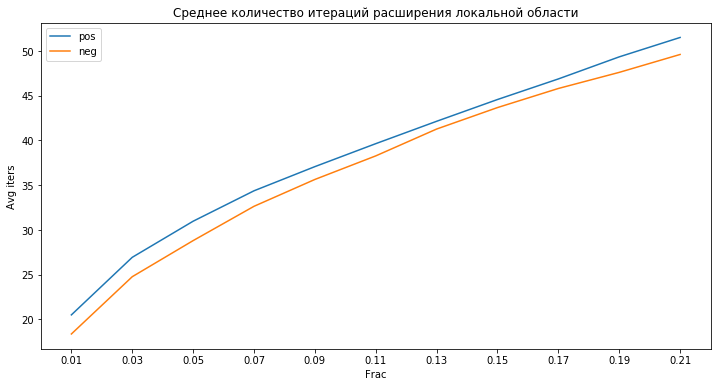

In [150]:
plt.figure(figsize=(12,6))
sns.lineplot(y='iters', x='frac', data=iterations_list_pos, label='pos')
sns.lineplot(y='iters', x='frac', data=iterations_list_neg, label='neg')
plt.ylabel('Avg iters')
plt.xlabel('Frac')
plt.title('Среднее количество итераций расширения локальной области')
plt.legend()
plt.savefig('images/AvgItersLocalExpanding.png')

    Измененный вариант отбора объектов, по которым будут искаться гипотезы
    Будем смотреть объекты обучающей выборки, которые находятся в локальной области тестового объекта
    На рисунке представлен график изменения объектов обучающей выборки для каждого класса. По оси Х представлена доля объектов из обучающей выборки, а по оси Y - количество итераций расширения локальной области, которое необходимо произвести, чтобы определенная доля объектов из выборки оказалась в локальной области объекта

**Исследование количества генерируемых гипотез в зависимости от набора параметров для нового подхода отбора гипотез**

*Сначала проверим построение старого подхода генерации гипотез*

In [294]:
alpha_params = [0.001, 0.002, 0.003, 0.004]
sample_ratio_params = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01]

results_pos = {}
results_neg = {}
pos_hyps = []
neg_hyps = []

for alpha in alpha_params:
    results_pos[alpha] = {}
    results_neg[alpha] = {}
    
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        results_pos[alpha][sample_ratio] = []
        results_neg[alpha][sample_ratio] = []

In [295]:
params = {
    'train_pos': train_pos,
    'train_neg': train_neg,
    'num_iters': 300,
    'hypothesis_criterion': 'contr_class',
    'sample_type': 'random',
    'trainx_min': trainx_min,
    'trainx_max': trainx_max,
    'verbose': False,
    'n_jobs': 4
}

In [296]:
%%time
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        for i, obj in test_sample[4:5].iterrows():
            print(f"""using params: alpha = {alpha}, \n
            sample_ratio = {sample_ratio},\n
            num_iters = {params['num_iters']}""")
            pos_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='pos', **params)
            
            pos_hyps_shape = pd.DataFrame(pos_hyps).shape[0] if len(pos_hyps) > 0 else 0
            results_pos[alpha][sample_ratio].append(pos_hyps_shape)
            
            neg_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='neg', **params)
            
            neg_hyps_shape = pd.DataFrame(neg_hyps).shape[0] if len(neg_hyps) > 0 else 0
            results_neg[alpha][sample_ratio].append(neg_hyps_shape)

using params: alpha = 0.004, 

            sample_ratio = 0.004,

            num_iters = 300
start generating hypothesises
Use params: sample_type = random
object area is None
num_iters = 300
expanding iters = 50
fraction = 0.25
iteration: 0
iteration: 100
iteration: 200
start generating hypothesises
Use params: sample_type = random
object area is None
num_iters = 300
expanding iters = 50
fraction = 0.25
iteration: 0
iteration: 100
iteration: 200
CPU times: user 4.5 s, sys: 460 ms, total: 4.96 s
Wall time: 1min


In [62]:
with open('results/total_results_pos.txt', 'r') as f:
    results_pos_str = f.read()
    
results_pos = json.loads(results_pos_str)

In [63]:
with open('results/total_results_neg.txt', 'r') as f:
    results_neg_str = f.read()
    
results_neg = json.loads(results_neg_str)

In [64]:
for alpha in results_pos:
    for sample_ratio in results_pos[alpha]:
        results_pos[alpha][sample_ratio] = np.mean(results_pos[alpha][sample_ratio])
        
for alpha in results_neg:
    for sample_ratio in results_neg[alpha]:
        results_neg[alpha][sample_ratio] = np.mean(results_neg[alpha][sample_ratio])

In [72]:
results_pos = pd.DataFrame.from_dict(results_pos)
results_neg = pd.DataFrame.from_dict(results_neg)

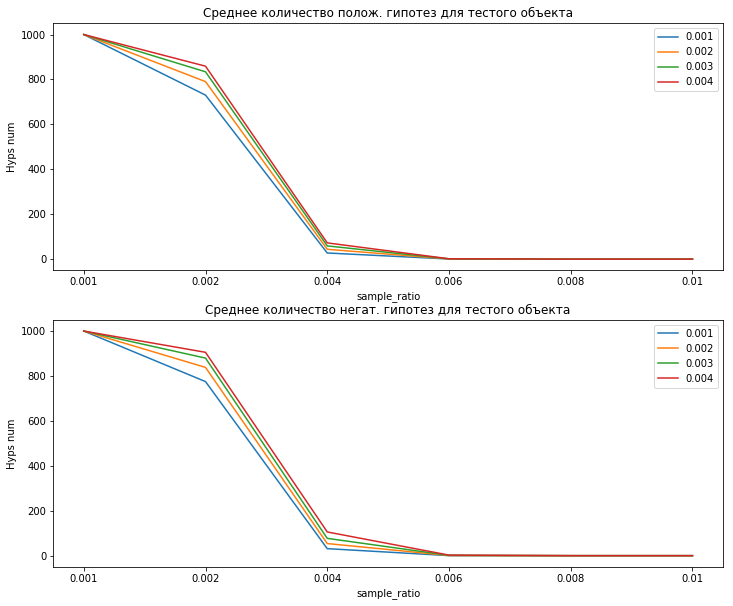

In [138]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
for col in results_pos.columns:
    ax1.plot(results_pos[col].index, results_pos[col].values, label=col)
    ax1.set_xlabel('sample_ratio')
    ax1.set_ylabel('Hyps num')
    ax1.set_title("Среднее количество полож. гипотез для тестого объекта")
    ax1.legend()
    
for col in results_neg.columns:
    ax2.plot(results_neg[col].index, results_neg[col].values, label=col)
    ax2.set_xlabel('sample_ratio')
    ax2.set_ylabel('Hyps num')
    ax2.set_title("Среднее количество негат. гипотез для тестого объекта")
    ax2.legend()
    
# plt.savefig(fname='images/avg_num_hyps_results.png')

In [129]:
ls -la -h images/

total 200
drwxr-xr-x   4 adam  staff   128B Feb 13 17:50 ./
drwxr-xr-x  24 adam  staff   768B Feb 13 17:51 ../
-rw-r--r--   1 adam  staff    29K Feb  7 19:00 AvgItersLocalExpanding.png
-rw-r--r--   1 adam  staff    67K Feb 13 17:53 avg_num_hyps_results.png


**Новый подход генерации гипотез**

In [309]:
alpha_params = [2.0]#, 1.05, 1.1, 1.3, 1.5, 1.7, 2.0]
sample_ratio_params = [0.002]#, 0.002, 0.004, 0.006, 0.008, 0.01]

results_pos = {}
results_neg = {}
pos_hyps = []
neg_hyps = []

for alpha in alpha_params:
    results_pos[alpha] = {}
    results_neg[alpha] = {}
    
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        results_pos[alpha][sample_ratio] = []
        results_neg[alpha][sample_ratio] = []

In [310]:
print(results_pos)
print(results_neg)

{2.0: {0.002: []}}
{2.0: {0.002: []}}


In [313]:
params = {
    'train_pos': train_pos,
    'train_neg': train_neg,
    'num_iters': 200,
    'hypothesis_criterion': 'both_classes',
    'sample_type': 'local',
    'trainx_min': trainx_min,
    'trainx_max': trainx_max,
    'fraction': 0.17,
    'expanding_iters': 120, #максимальное количество итераций расширения
    'verbose': False,
    'n_jobs': 4
}

In [314]:
utils = imp.reload(utils)

In [315]:
%%time
for alpha in alpha_params:
    for sample_ratio in sample_ratio_params:
        for i, obj in test_sample.iterrows():
            print(f"""using params: alpha = {alpha}, \n
                sample_ratio = {sample_ratio}, \n
                num_iters = {params['num_iters']}""")
            pos_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='pos', **params)
            
            pos_hyps_shape = pd.DataFrame(pos_hyps).shape[0] if len(pos_hyps) > 0 else 0
            results_pos[alpha][sample_ratio].append(pos_hyps_shape)
            
            neg_hyps = mining_step(test_obj=obj, sample_ratio=sample_ratio, alpha = alpha,
                                   mining_type='neg',**params)
            
            neg_hyps_shape = pd.DataFrame(neg_hyps).shape[0] if len(neg_hyps) > 0 else 0
            results_neg[alpha][sample_ratio].append(neg_hyps_shape)

using params: alpha = 2.0, 

                sample_ratio = 0.002, 

                num_iters = 200
start generating hypothesises
start searching optimal local area
itr: 10
itr: 20
itr: 30
itr: 40
Use params: sample_type = local
object area is not None
num_iters = 200
expanding iters = 120
fraction = 0.17
iteration: 0
iteration: 100
start generating hypothesises
start searching optimal local area
itr: 10
itr: 20
itr: 30
Use params: sample_type = local
object area is not None
num_iters = 200
expanding iters = 120
fraction = 0.17
iteration: 0
iteration: 100
CPU times: user 22.1 s, sys: 873 ms, total: 22.9 s
Wall time: 2min 18s


In [78]:
ls results

local_total_results_neg.txt      local_total_results_pos_upd.txt
local_total_results_neg_upd.txt  total_results_neg.txt
local_total_results_pos.txt      total_results_pos.txt


In [79]:
with open('results/local_total_results_pos_upd.txt', 'r') as f:
    local_results_pos_str = f.read()
    
local_results_pos = json.loads(local_results_pos_str)
print(local_results_pos)

{'1.0': {'0.001': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], '0.002': [990, 940, 897, 901, 843, 966, 970, 875, 913, 891, 941, 957, 900, 858, 965, 883, 907, 924, 910, 930, 900, 959, 906, 953, 887, 994, 884, 915, 960, 997], '0.004': [995, 648, 218, 376, 599, 691, 954, 253, 333, 516, 531, 805, 263, 173, 803, 245, 363, 472, 389, 505, 299, 902, 399, 885, 191, 997, 316, 330, 835, 1000], '0.006': [1000, 511, 36, 133, 539, 517, 990, 48, 99, 261, 335, 795, 39, 24, 836, 52, 170, 259, 166, 275, 81, 915, 124, 897, 17, 1000, 55, 95, 851, 1000], '0.008': [1000, 437, 4, 66, 554, 440, 997, 10, 21, 117, 248, 848, 6, 4, 878, 13, 72, 163, 83, 149, 18, 949, 41, 949, 6, 1000, 12, 31, 900, 1000], '0.01': [1000, 401, 0, 33, 570, 415, 1000, 3, 7, 66, 214, 913, 4, 0, 928, 0, 37, 148, 45, 61, 4, 977, 9, 981, 1, 1000, 5, 9, 947, 1000]}, '1.1': {'0.001': [1000, 1000, 1000, 100

In [80]:
with open('results/local_total_results_neg_upd.txt', 'r') as f:
    local_results_neg_str = f.read()
    
local_results_neg = json.loads(local_results_neg_str)
print(local_results_neg)

{'1.0': {'0.001': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], '0.002': [893, 984, 993, 997, 974, 996, 987, 998, 987, 996, 983, 982, 999, 999, 989, 998, 998, 990, 1000, 986, 995, 963, 985, 965, 992, 920, 999, 997, 982, 899], '0.004': [566, 993, 999, 1000, 986, 999, 958, 1000, 991, 999, 984, 969, 1000, 1000, 959, 1000, 1000, 995, 1000, 985, 988, 925, 995, 932, 1000, 716, 1000, 1000, 950, 563], '0.006': [380, 997, 1000, 1000, 992, 1000, 957, 1000, 1000, 1000, 997, 973, 1000, 1000, 960, 1000, 1000, 1000, 1000, 997, 999, 932, 1000, 931, 1000, 591, 1000, 1000, 950, 397], '0.008': [263, 1000, 1000, 1000, 994, 1000, 946, 1000, 1000, 1000, 999, 962, 1000, 1000, 952, 1000, 1000, 1000, 1000, 1000, 1000, 939, 1000, 939, 1000, 502, 1000, 1000, 929, 270], '0.01': [183, 1000, 1000, 1000, 993, 1000, 924, 1000, 1000, 1000, 1000, 958, 1000, 1000, 937, 1000, 1000, 1000

In [84]:
local_results_pos['2.0']

{'0.001': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
 '0.002': [772, 939, 904, 936, 888, 753, 700, 705, 744, 750],
 '0.004': [123, 740, 373, 707, 872, 59, 36, 208, 97, 52],
 '0.006': [9, 769, 136, 659, 965, 0, 1, 80, 18, 2],
 '0.008': [0, 820, 80, 698, 990, 0, 0, 49, 0, 0],
 '0.01': [0, 889, 51, 673, 998, 0, 0, 36, 0, 0]}

In [85]:
for alpha in local_results_pos:
    for sample_ratio in local_results_pos[alpha]:
        local_results_pos[alpha][sample_ratio] = np.mean(local_results_pos[alpha][sample_ratio])
local_results_pos

{'1.0': {'0.001': 1000.0,
  '0.002': 923.8666666666667,
  '0.004': 542.8666666666667,
  '0.006': 404.0,
  '0.008': 367.2,
  '0.01': 359.26666666666665},
 '1.1': {'0.001': 1000.0,
  '0.002': 912.6,
  '0.004': 532.1,
  '0.006': 446.1,
  '0.008': 434.0,
  '0.01': 428.5},
 '1.3': {'0.001': 1000.0,
  '0.002': 907.0,
  '0.004': 482.0,
  '0.006': 401.6,
  '0.008': 376.2,
  '0.01': 372.8},
 '1.5': {'0.001': 1000.0,
  '0.002': 889.6,
  '0.004': 429.2,
  '0.006': 357.1,
  '0.008': 335.9,
  '0.01': 334.6},
 '1.7': {'0.001': 1000.0,
  '0.002': 888.8,
  '0.004': 394.9,
  '0.006': 319.3,
  '0.008': 313.0,
  '0.01': 306.8},
 '2.0': {'0.001': 1000.0,
  '0.002': 809.1,
  '0.004': 326.7,
  '0.006': 263.9,
  '0.008': 263.7,
  '0.01': 264.7},
 '3.0': {'0.001': 174.4,
  '0.002': 697.6,
  '0.004': 80.0,
  '0.006': 8.8,
  '0.008': 1.8,
  '0.01': 0.5},
 '4.0': {'0.001': 174.2,
  '0.002': 701.1,
  '0.004': 60.8,
  '0.006': 5.4,
  '0.008': 0.5,
  '0.01': 0.3},
 '5.0': {'0.001': 174.1,
  '0.002': 692.3,
  '0.004

In [86]:
for alpha in local_results_neg:
    for sample_ratio in local_results_neg[alpha]:
        local_results_neg[alpha][sample_ratio] = np.mean(local_results_neg[alpha][sample_ratio])
local_results_neg

{'1.0': {'0.001': 1000.0,
  '0.002': 980.8666666666667,
  '0.004': 948.4,
  '0.006': 935.1,
  '0.008': 923.1666666666666,
  '0.01': 912.1},
 '1.1': {'0.001': 1000.0,
  '0.002': 976.3,
  '0.004': 897.2,
  '0.006': 849.2,
  '0.008': 806.5,
  '0.01': 777.5},
 '1.3': {'0.001': 1000.0,
  '0.002': 971.1,
  '0.004': 849.2,
  '0.006': 777.5,
  '0.008': 733.8,
  '0.01': 698.5},
 '1.5': {'0.001': 1000.0,
  '0.002': 961.6,
  '0.004': 801.2,
  '0.006': 711.9,
  '0.008': 670.5,
  '0.01': 642.9},
 '1.7': {'0.001': 1000.0,
  '0.002': 955.6,
  '0.004': 762.1,
  '0.006': 674.0,
  '0.008': 629.9,
  '0.01': 607.4},
 '2.0': {'0.001': 1000.0,
  '0.002': 902.7,
  '0.004': 700.5,
  '0.006': 623.3,
  '0.008': 591.4,
  '0.01': 570.2},
 '3.0': {'0.001': 177.0,
  '0.002': 912.2,
  '0.004': 898.7,
  '0.006': 881.2,
  '0.008': 862.6,
  '0.01': 841.7},
 '4.0': {'0.001': 177.0,
  '0.002': 905.1,
  '0.004': 797.9,
  '0.006': 737.5,
  '0.008': 685.7,
  '0.01': 637.5},
 '5.0': {'0.001': 177.0,
  '0.002': 890.2,
  '0.00

In [87]:
local_results_pos = pd.DataFrame.from_dict(local_results_pos)
local_results_neg = pd.DataFrame.from_dict(local_results_neg)

In [88]:
local_results_pos

,1.0,1.1,1.3,1.5,1.7,2.0,3.0,4.0,5.0,7.0,10,12,15
0.001,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,174.4,174.2,174.1,174.2,174.0,174.2,174.3
0.002,923.866667,912.6,907.0,889.6,888.8,809.1,697.6,701.1,692.3,694.5,692.6,697.6,691.9
0.004,542.866667,532.1,482.0,429.2,394.9,326.7,80.0,60.8,45.1,37.2,28.3,26.6,29.7
0.006,404.000000,446.1,401.6,357.1,319.3,263.9,8.8,5.4,3.3,2.0,1.6,0.5,0.6
0.008,367.200000,434.0,376.2,335.9,313.0,263.7,1.8,0.5,0.2,0.1,0.1,0.1,0.1
0.01,359.266667,428.5,372.8,334.6,306.8,264.7,0.5,0.3,0.0,0.0,0.0,0.0,0.0


In [90]:
local_results_neg

,1.0,1.1,1.3,1.5,1.7,2.0,3.0,4.0,5.0,7.0,10,12,15
0.001,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,177.0,177.0,177.0,177.1,177.0,176.9,177.1
0.002,980.866667,976.3,971.1,961.6,955.6,902.7,912.2,905.1,890.2,883.4,876.7,876.6,878.8
0.004,948.400000,897.2,849.2,801.2,762.1,700.5,898.7,797.9,703.4,557.6,438.1,387.4,334.5
0.006,935.100000,849.2,777.5,711.9,674.0,623.3,881.2,737.5,601.6,441.6,302.9,251.4,185.0
0.008,923.166667,806.5,733.8,670.5,629.9,591.4,862.6,685.7,537.5,378.1,248.8,186.5,127.7
0.01,912.100000,777.5,698.5,642.9,607.4,570.2,841.7,637.5,489.8,351.0,216.0,152.4,93.5


In [112]:
ls images/

AvgItersLocalExpanding.png       AvgLocalHypsNum_low_params.png
AvgLocalHypsNum_high_params.png  avg_num_hyps_results.png


In [108]:
def plot_local_sampling_results(local_results_pos, local_results_neg, columns, img_title):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    for col in columns:
        ax1.plot(local_results_pos[col].index, local_results_pos[col].values, label=col)
        ax1.set_xlabel('sample_ratio')
        ax1.set_ylabel('Hyps num')
        ax1.set_title("Среднее количество полож. гипотез для тестого объекта")
        ax1.legend()

    for col in columns:
        ax2.plot(local_results_neg[col].index, local_results_neg[col].values, label=col)
        ax2.set_xlabel('sample_ratio')
        ax2.set_ylabel('Hyps num')
        ax2.set_title("Среднее количество негат. гипотез для тестого объекта")
        ax2.legend()
        
    plt.savefig(f"images/{img_title}.png")

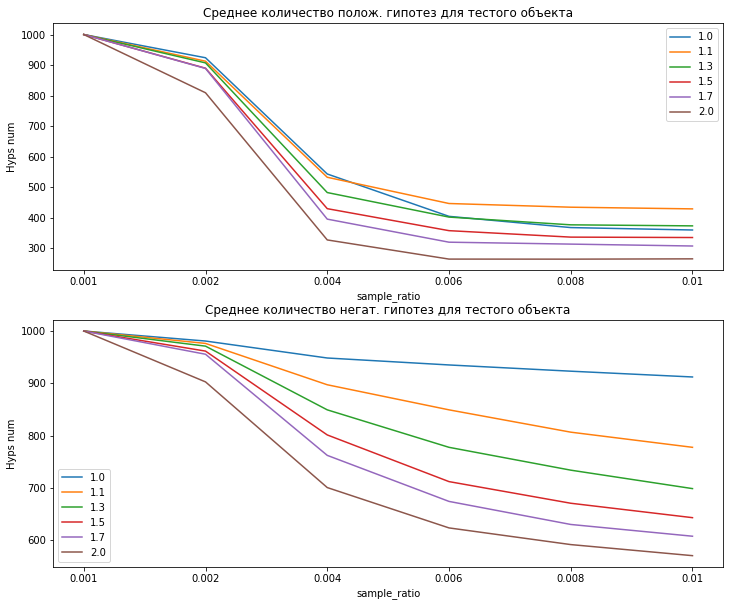

In [109]:
plot_local_sampling_results(local_results_pos=local_results_pos,
                            local_results_neg=local_results_neg, 
                            columns=local_results_pos.columns[:6],
                            img_title='AvgLocalHypsNum_low_params')

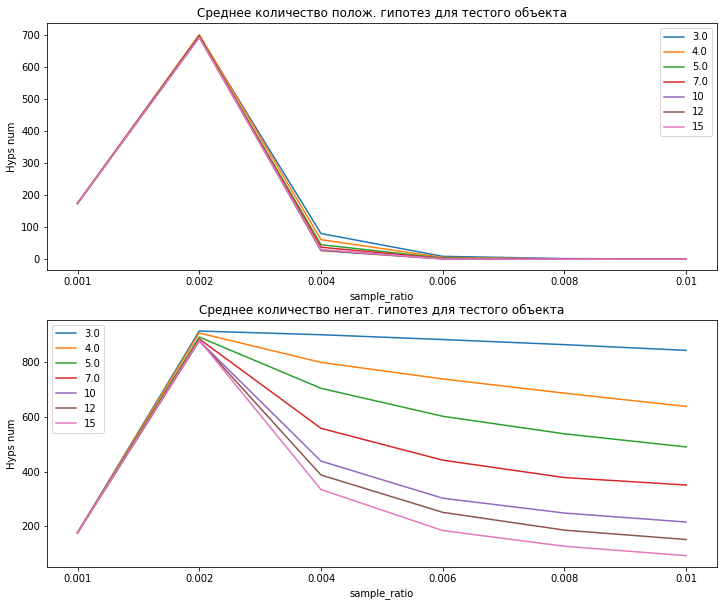

In [111]:
plot_local_sampling_results(local_results_pos=local_results_pos, 
                            local_results_neg=local_results_neg, 
                            columns=local_results_pos.columns[6:],
                            img_title='AvgLocalHypsNum_high_params')